In [1]:
# OPTIONAL: Load the "autoreload" eX_orig[alias]tension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

# Consistency Analysis

- Look at actual control average profile
- Look at psuedo control average profile
- Compare consistencies between psuedo and real controls

In [2]:
import umap
import seaborn as sns
from scipy import stats
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from skbio.stats.composition import clr
from sklearn.covariance import MinCovDet
from statannotations.Annotator import Annotator
from adjustText import adjust_text
from PIL import Image as PILImage

from src.config import get_experiment_artifacts, SAMPLE, PAIRED_SAMPLES
from src.util import calculate_difference_to_controls
from src.models.outliers import logratio_outlier_detection


# Show images inline
from IPython.display import Image

# Standard library packages
import io
import os

# Import Biopython modules to interact with KEGG
from Bio import SeqIO
from Bio.KEGG import REST
from Bio.KEGG.KGML import KGML_parser
from Bio.Graphics.KGML_vis import KGMLCanvas


In [3]:
Z_sample = pkl.load(open("{}/imputed_adamson_sample_data.pkl".format(get_experiment_artifacts(profile_type=SAMPLE)), "rb"))
Z_paired = pkl.load(open("{}/imputed_adamson_sample_data.pkl".format(get_experiment_artifacts(profile_type=PAIRED_SAMPLES)), "rb"))
d_sample = pd.concat(Z_sample, axis=1)
d_paired = pd.concat(Z_paired, axis=1)

In [4]:
controls = d_sample.index[d_sample.index.str.contains("non-")].to_list()
controls[:5]

['non-targeting_000',
 'non-targeting_001',
 'non-targeting_002',
 'non-targeting_003',
 'non-targeting_005']

In [5]:
Xall_paired = d_paired.stack().stack()\
    .to_frame().reset_index()\
    .rename(columns={"level_2": "Sample", 0: "Value"})\
    .pivot(index=["Sample", "Gene"], columns=["lumc_category"], values="Value")
Xall_paired.head()

lumc_category      Any Insertion  Deletion 0bp microhomology  \
Sample     Gene                                                
Adamson_T1 Actl6a       0.169872                    0.182632   
           Actr5        0.152818                    0.188649   
           Actr8        0.137595                    0.197087   
           Aicda        0.132990                    0.189794   
           Alkbh2       0.133315                    0.191525   

lumc_category      Deletion 1bp microhomology  Deletion 2bp microhomology  \
Sample     Gene                                                             
Adamson_T1 Actl6a                    0.367412                    0.053167   
           Actr5                     0.370201                    0.043995   
           Actr8                     0.374039                    0.052188   
           Aicda                     0.366840                    0.059621   
           Alkbh2                    0.363685                    0.058760   

lumc_category      Deletion 3+bp microhomology  Deletion with insertion  \
Sample     Gene                                                           
Adamson_T1 Actl6a                     0.030775                 0.157311   
           Actr5                      0.030975                 0.165087   
           Actr8                      0.028203                 0.159505   
           Aicda                      0.034540                 0.165860   
           Alkbh2                     0.036163                 0.163226   

lumc_category      Homology Directed Repair  
Sample     Gene                              
Adamson_T1 Actl6a                  0.038832  
           Actr5                   0.048275  
           Actr8                   0.051384  
           Aicda                   0.050356  
           Alkbh2                  0.053326

In [6]:
Xall_sample = d_sample.stack().stack()\
    .to_frame().reset_index()\
    .rename(columns={"level_2": "Sample", 0: "Value"})\
    .pivot(index=["Sample", "Gene"], columns=["lumc_category"], values="Value")
Xall_sample.head()

lumc_category                                       Any Insertion  \
Sample                                      Gene                    
K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1 Actl6a       0.179460   
                                            Actr5        0.160807   
                                            Actr8        0.144000   
                                            Aicda        0.138997   
                                            Alkbh2       0.140536   

lumc_category                                       Deletion 0bp microhomology  \
Sample                                      Gene                                 
K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1 Actl6a                    0.176425   
                                            Actr5                     0.181376   
                                            Actr8                     0.190534   
                                            Aicda                     0.184504   
                                            Alkbh2                    0.189304   

lumc_category                                       Deletion 1bp microhomology  \
Sample                                      Gene                                 
K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1 Actl6a                    0.362053   
                                            Actr5                     0.369397   
                                            Actr8                     0.373348   
                                            Aicda                     0.364239   
                                            Alkbh2                    0.356852   

lumc_category                                       Deletion 2bp microhomology  \
Sample                                      Gene                                 
K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1 Actl6a                    0.049512   
                                            Actr5                     0.039925   
                                            Actr8                     0.049253   
                                            Aicda                     0.056348   
                                            Alkbh2                    0.054539   

lumc_category                                       Deletion 3+bp microhomology  \
Sample                                      Gene                                  
K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1 Actl6a                     0.026915   
                                            Actr5                      0.029638   
                                            Actr8                      0.026359   
                                            Aicda                      0.034072   
                                            Alkbh2                     0.035961   

lumc_category                                       Deletion with insertion  \
Sample                                      Gene                              
K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1 Actl6a                 0.168670   
                                            Actr5                  0.170009   
                                            Actr8                  0.166768   
                                            Aicda                  0.172529   
                                            Alkbh2                 0.170885   

lumc_category                                       Homology Directed Repair  
Sample                                      Gene                              
K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1 Actl6a                  0.036964  
                                            Actr5                   0.048849  
                                            Actr8                   0.049737  
                                            Aicda                   0.049311  
                                            Alkbh2                  0.051923

In [7]:
results = {}
for alias in Z_paired.keys():
    pca_scores, loadings, explained_variance_ratio, distances, pvalues = logratio_outlier_detection(Z_paired[alias], MinCovDet(random_state=0))
    results[alias] = pca_scores, loadings, explained_variance_ratio, distances, pvalues
    results[alias] = pd.Series(distances, index=Z_paired[alias].index).sort_values(ascending=False)

In [8]:
pseudo_controls = results[alias].iloc[-len(controls):].index.to_series()
pseudo_controls[:5]

Gene
non-targeting_002    non-targeting_002
Psip1                            Psip1
non-targeting_029    non-targeting_029
Bcl7b                            Bcl7b
Msh4                              Msh4
Name: Gene, dtype: object

In [9]:
idx = pd.IndexSlice
other_genes = set(Xall_paired.index.unique(1)) - set(controls) - set(pseudo_controls)
other_genes = list(other_genes)

Xdiff = calculate_difference_to_controls(Xall_sample, controls, d_sample.columns.unique(0))
Xdiff = Xdiff.loc[other_genes]

Xpseudodiff = {}
for alias in Z_sample.keys():
    Xpseudodiff[alias] = calculate_difference_to_controls(Xall_sample.loc[Xall_sample.index.get_level_values(0) == alias, :],\
                            pseudo_controls, [alias]).loc[other_genes]

(992, 7)
(58, 7)
(496, 14)
(14,)
(496, 14)
(496, 7)
(29, 7)
(496, 7)
(7,)
(496, 7)
(496, 7)
(29, 7)
(496, 7)
(7,)
(496, 7)


In [10]:
Xdiff.head()

Sample        K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1  \
lumc_category                               Any Insertion   
Gene                                                        
Fancl                                            0.022798   
Pold3                                            0.045986   
Znhit1                                           0.000321   
Ppp4r1                                          -0.002064   
Phc3                                             0.001399   

Sample                                                               \
lumc_category Deletion 0bp microhomology Deletion 1bp microhomology   
Gene                                                                  
Fancl                           0.005282                   0.013864   
Pold3                           0.033899                  -0.045651   
Znhit1                          0.002935                   0.001931   
Ppp4r1                         -0.006220                   0.002404   
Phc3                           -0.003224                  -0.003240   

Sample                                                                \
lumc_category Deletion 2bp microhomology Deletion 3+bp microhomology   
Gene                                                                   
Fancl                           0.008969                    0.004574   
Pold3                           0.013955                    0.015628   
Znhit1                          0.003790                    0.004374   
Ppp4r1                         -0.003389                    0.001372   
Phc3                            0.001157                   -0.001844   

Sample                                                          \
lumc_category Deletion with insertion Homology Directed Repair   
Gene                                                             
Fancl                       -0.038769                -0.016718   
Pold3                       -0.032812                -0.031005   
Znhit1                      -0.010162                -0.003188   
Ppp4r1                       0.003622                 0.004274   
Phc3                         0.003180                 0.002572   

Sample        K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2  \
lumc_category                               Any Insertion   
Gene                                                        
Fancl                                            0.023835   
Pold3                                            0.031383   
Znhit1                                           0.005754   
Ppp4r1                                           0.005505   
Phc3                                             0.004608   

Sample                                                               \
lumc_category Deletion 0bp microhomology Deletion 1bp microhomology   
Gene                                                                  
Fancl                           0.016989                   0.018000   
Pold3                           0.035521                  -0.059349   
Znhit1                         -0.000484                  -0.000085   
Ppp4r1                         -0.002742                  -0.005831   
Phc3                            0.000745                  -0.001619   

Sample                                                                \
lumc_category Deletion 2bp microhomology Deletion 3+bp microhomology   
Gene                                                                   
Fancl                           0.007862                    0.005271   
Pold3                           0.023852                    0.022408   
Znhit1                          0.011149                    0.002488   
Ppp4r1                         -0.002635                    0.005435   
Phc3                            0.000303                   -0.003840   

Sample                                                          
lumc_category Deletion with insertion Homology Directed Repair  
Gene                                                            
Fancl 

In [11]:
Xpseudodiff = pd.concat(Xpseudodiff.values(), axis=1)
Xpseudodiff.head()

Sample        K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1  \
lumc_category                               Any Insertion   
Gene                                                        
Fancl                                            0.022936   
Pold3                                            0.046124   
Znhit1                                           0.000459   
Ppp4r1                                          -0.001927   
Phc3                                             0.001537   

Sample                                                               \
lumc_category Deletion 0bp microhomology Deletion 1bp microhomology   
Gene                                                                  
Fancl                           0.005415                   0.016285   
Pold3                           0.034033                  -0.043230   
Znhit1                          0.003068                   0.004352   
Ppp4r1                         -0.006086                   0.004826   
Phc3                           -0.003090                  -0.000818   

Sample                                                                \
lumc_category Deletion 2bp microhomology Deletion 3+bp microhomology   
Gene                                                                   
Fancl                           0.008937                    0.004691   
Pold3                           0.013922                    0.015745   
Znhit1                          0.003757                    0.004491   
Ppp4r1                         -0.003421                    0.001489   
Phc3                            0.001124                   -0.001727   

Sample                                                          \
lumc_category Deletion with insertion Homology Directed Repair   
Gene                                                             
Fancl                       -0.040719                -0.017545   
Pold3                       -0.034761                -0.031833   
Znhit1                      -0.012112                -0.004016   
Ppp4r1                       0.001673                 0.003447   
Phc3                         0.001230                 0.001744   

Sample        K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2  \
lumc_category                               Any Insertion   
Gene                                                        
Fancl                                            0.022585   
Pold3                                            0.030133   
Znhit1                                           0.004504   
Ppp4r1                                           0.004255   
Phc3                                             0.003358   

Sample                                                               \
lumc_category Deletion 0bp microhomology Deletion 1bp microhomology   
Gene                                                                  
Fancl                           0.017947                   0.019078   
Pold3                           0.036479                  -0.058271   
Znhit1                          0.000473                   0.000992   
Ppp4r1                         -0.001784                  -0.004753   
Phc3                            0.001703                  -0.000541   

Sample                                                                \
lumc_category Deletion 2bp microhomology Deletion 3+bp microhomology   
Gene                                                                   
Fancl                           0.007431                    0.004402   
Pold3                           0.023421                    0.021538   
Znhit1                          0.010717                    0.001618   
Ppp4r1                         -0.003067                    0.004566   
Phc3                           -0.000129                   -0.004710   

Sample                                                          
lumc_category Deletion with insertion Homology Directed Repair  
Gene                                                            
Fancl 

In [12]:
def consistency(x, change_df, sample1, sample2):
    return stats.spearmanr(change_df.loc[x,sample1].dropna(), change_df.loc[x,sample2].dropna())[0]

real_c = Xdiff.index.to_series().apply(lambda x: consistency(x, Xdiff, \
            "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1", "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2"))
pseudo_c = Xpseudodiff.index.to_series().apply(lambda x: consistency(x, Xpseudodiff, \
            "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1", "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2"))

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

real vs. pseudo: Wilcoxon test (paired samples), P_val:1.975e-01 Stat=2.370e+04


(<AxesSubplot: title={'center': 'Consistency of remaining genes vs different controls'}, xlabel='Type', ylabel='Consistency'>,
 [<statannotations.Annotation.Annotation at 0x1686c6f70>])

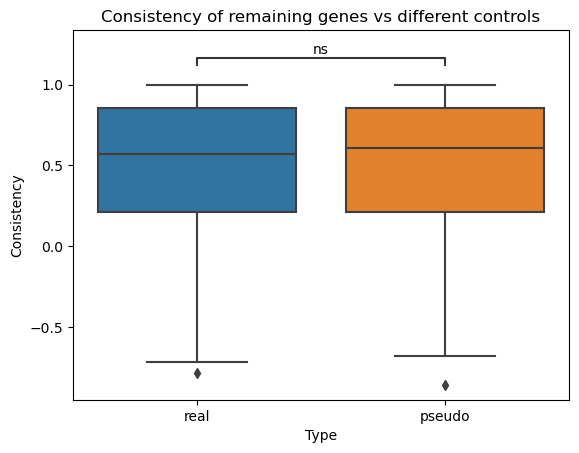

In [13]:
c = pd.DataFrame({
    "real": real_c,
    "pseudo": pseudo_c
}).stack()\
.to_frame()\
.reset_index()\
.rename(columns={"level_1": "Type", 0: "Consistency"})
ax = sns.boxplot(data=c, x="Type", y="Consistency")
plt.title("Consistency of remaining genes vs different controls")

pairs=[("real", "pseudo")]
annotator = Annotator(ax, pairs, data=c, x="Type", y="Consistency")
annotator.configure(test='Wilcoxon', text_format='star', loc='inside')
annotator.apply_and_annotate()

In [14]:
idx = pd.IndexSlice
Xcontrol = Xall_paired.loc[idx[:, controls], :]
Xcontrolmean = pd.DataFrame(Xcontrol.groupby("Sample").apply(stats.gmean).tolist()\
                            , index=Z_paired.keys(), columns=Xcontrol.columns)
Xcontrolmean["Group"] = "Real"
Xcontrolmean

lumc_category,Any Insertion,Deletion 0bp microhomology,Deletion 1bp microhomology,Deletion 2bp microhomology,Deletion 3+bp microhomology,Deletion with insertion,Homology Directed Repair,Group
Adamson_T1,0.133083,0.19362,0.368162,0.057366,0.034597,0.162986,0.049841,Real


In [15]:
Xmean = pd.DataFrame(Xall_paired.groupby("Sample").apply(stats.gmean).tolist()\
                            , index=Z_paired.keys(), columns=Xcontrol.columns)
Xmean

lumc_category,Any Insertion,Deletion 0bp microhomology,Deletion 1bp microhomology,Deletion 2bp microhomology,Deletion 3+bp microhomology,Deletion with insertion,Homology Directed Repair
Adamson_T1,0.138306,0.193694,0.366285,0.057239,0.035097,0.156808,0.045142


In [16]:

Xpseudocontrol = {}
Xpseudocontrolmean = {}
for alias in Z_paired.keys():
    Xpseudocontrol[alias] = Xall_paired.loc[idx[alias, pseudo_controls], :]
    Xpseudocontrolmean[alias] = pd.DataFrame(Xpseudocontrol[alias].groupby("Sample").apply(stats.gmean).tolist()\
                                , index=[alias], columns=Xpseudocontrol[alias].columns)
    Xpseudocontrolmean[alias]["Group"] = "Pseudo"
Xpseudocontrolmean = pd.concat(Xpseudocontrolmean.values())
Xpseudocontrolmean

lumc_category,Any Insertion,Deletion 0bp microhomology,Deletion 1bp microhomology,Deletion 2bp microhomology,Deletion 3+bp microhomology,Deletion with insertion,Homology Directed Repair,Group
Adamson_T1,0.133716,0.193149,0.366527,0.057606,0.034969,0.16348,0.05049,Pseudo


In [17]:
bootstrapped_pseudo_control_means = []
for alias in Z_paired.keys():
    for i in range(10000):
        bootstrapped_pseudo_controls = Xall_paired.index.get_level_values(1).to_series().sample(n=29)
        bootstrapped_pseudo_control_profiles = Xall_paired.loc[idx[alias, bootstrapped_pseudo_controls], :]
        bootstrapped_pseudo_control_mean = pd.DataFrame(bootstrapped_pseudo_control_profiles.groupby("Sample").apply(stats.gmean).tolist()\
                                    , index=[i], columns=bootstrapped_pseudo_control_profiles.columns)
        bootstrapped_pseudo_control_means.append(bootstrapped_pseudo_control_mean)

bootstrapped_pseudo_control_means = pd.concat(bootstrapped_pseudo_control_means, axis=0)

In [18]:
np.intersect1d(bootstrapped_pseudo_controls, pseudo_controls)

array(['Psip1'], dtype=object)

Text(0.010957677650304263, 570, 'Mean profile')

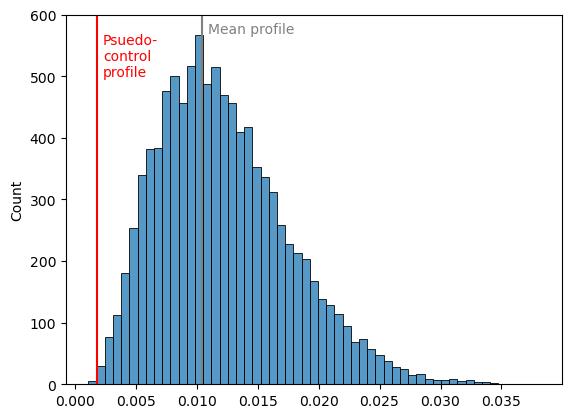

In [19]:
from scipy.spatial.distance import jensenshannon

pjsd = jensenshannon(Xpseudocontrolmean.iloc[0,:-1].to_list(), Xcontrolmean.iloc[0,:-1].to_list())
jsd = jensenshannon(Xmean.iloc[0,:].to_list(), Xcontrolmean.iloc[0,:-1].to_list())
jensha_dis = pd.Series(bootstrapped_pseudo_control_means.apply(lambda x: jensenshannon(x.to_list(), Xcontrolmean.iloc[0,:-1].to_list()), axis=1))

bootstrapped_means = {
    "bootstrapped": jensha_dis,
    "pseudo": pjsd,
    "actual": jsd
}
pkl.dump(bootstrapped_means, open("artifacts/jsd_estimates.pkl", "wb"))

sns.histplot(jensha_dis)
plt.axvline(pjsd, c="red")
plt.axvline(jsd, c="grey")
plt.ylim(0, 600)
plt.annotate("Psuedo-\ncontrol\nprofile", (pjsd + 0.0005, 500), c="red")
plt.annotate("Mean profile", (jsd + 0.0005, 570), c="grey")


In [20]:
(jensha_dis < pjsd).sum()/jensha_dis.shape[0]

0.0006

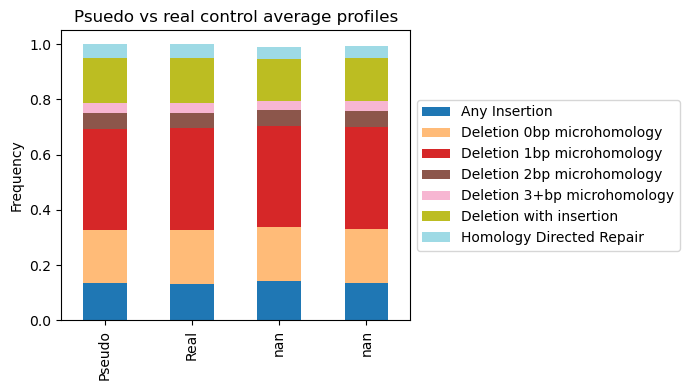

In [21]:
barplot_df = pd.concat([Xcontrolmean, Xpseudocontrolmean, bootstrapped_pseudo_control_means.loc[[0]], bootstrapped_pseudo_control_means.loc[[1]]])\
    .reset_index().rename(columns={"index": "Sample"}).drop("Sample", axis=1)
barplot_df = barplot_df.set_index(["Group"]).sort_index()
f = plt.figure(figsize=(7, 4))
ax = f.add_subplot(111)
plt.title('Psuedo vs real control average profiles', color='black')
barplot_df.plot(kind="bar", stacked=True, ax=f.gca(), colormap="tab20")
x = np.arange(0, 2)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel("Frequency")
plt.xlabel(None)
plt.tight_layout()

In [22]:
Xclrcontrolmean = pd.Series(clr(barplot_df.loc["Real"]), index=barplot_df.loc["Real"].index)
Xclrcontrolmean


lumc_category
Any Insertion                  0.225097
Deletion 0bp microhomology     0.600024
Deletion 1bp microhomology     1.242649
Deletion 2bp microhomology    -0.616414
Deletion 3+bp microhomology   -1.122102
Deletion with insertion        0.427789
Homology Directed Repair      -0.757045
dtype: float64

In [23]:
Xclrall = Xall_paired.copy()
Xclrall = pd.DataFrame(clr(Xclrall), index=Xclrall.index, columns=Xclrall.columns)
Xclrall.head()

lumc_category      Any Insertion  Deletion 0bp microhomology  \
Sample     Gene                                                
Adamson_T1 Actl6a       0.511247                    0.583671   
           Actr5        0.402988                    0.613625   
           Actr8        0.290313                    0.649646   
           Aicda        0.218625                    0.574293   
           Alkbh2       0.210278                    0.572580   

lumc_category      Deletion 1bp microhomology  Deletion 2bp microhomology  \
Sample     Gene                                                             
Adamson_T1 Actl6a                    1.282681                   -0.650370   
           Actr5                     1.287786                   -0.842191   
           Actr8                     1.290360                   -0.679147   
           Aicda                     1.233279                   -0.583636   
           Alkbh2                    1.213848                   -0.608978   

lumc_category      Deletion 3+bp microhomology  Deletion with insertion  \
Sample     Gene                                                           
Adamson_T1 Actl6a                    -1.197086                 0.434421   
           Actr5                     -1.193069                 0.480210   
           Actr8                     -1.294572                 0.438078   
           Aicda                     -1.129537                 0.439499   
           Alkbh2                    -1.094404                 0.412698   

lumc_category      Homology Directed Repair  
Sample     Gene                              
Adamson_T1 Actl6a                 -0.964564  
           Actr5                  -0.749348  
           Actr8                  -0.694678  
           Aicda                  -0.752523  
           Alkbh2                 -0.706022

In [24]:
from scipy.spatial.distance import euclidean

distances = pd.Series(Xclrall.apply(lambda x: euclidean(x, Xclrcontrolmean), axis=1), \
                             index=Xclrall.index)

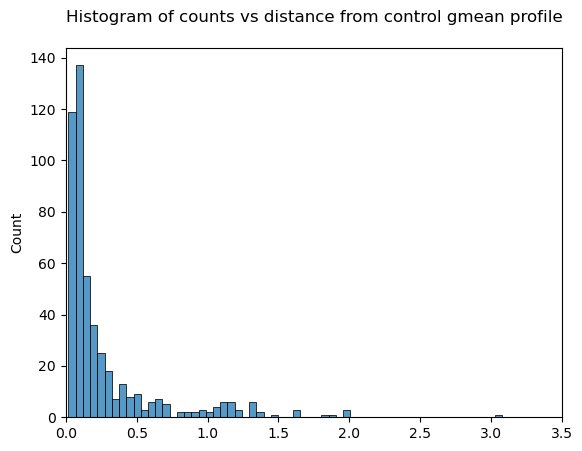

In [25]:
sns.histplot(distances)
plt.title("Histogram of counts vs distance from control gmean profile\n")
plt.xlim(0, 3.5)
plt.show()

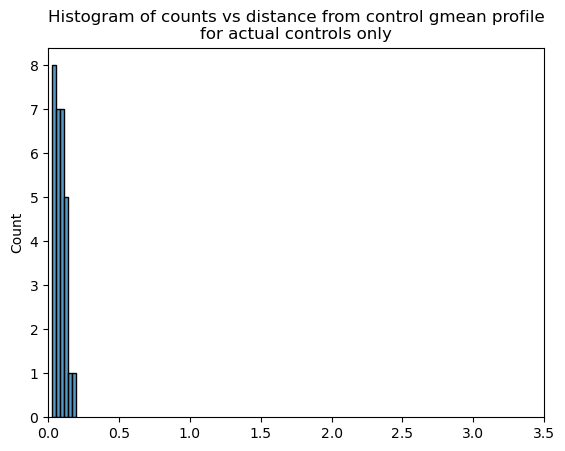

In [26]:
sns.histplot(distances.loc[distances.index.get_level_values(1).str.contains("non-")])
plt.title("Histogram of counts vs distance from control gmean profile\nfor actual controls only")
plt.xlim(0, 3.5)
plt.show()

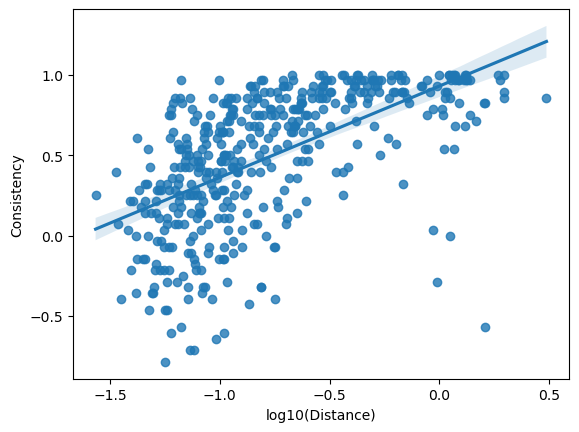

In [27]:
for alias in Z_paired.keys():
    sns.regplot(x = np.log10(distances.droplevel(0).loc[real_c.index]), y=real_c, x_ci = "sd")
    plt.ylabel("Consistency")
    plt.xlabel("log10(Distance)")

# def label_point(x, y, val, ax):
#     a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
#     for i, point in a.iterrows():
#         ax.text(point['x']+.02, point['y'], str(point['val']))

# label_point(np.log10(distances.droplevel(0).loc[real_c.index]), real_c, real_c.index.to_series(), plt.gca())
plt.show()

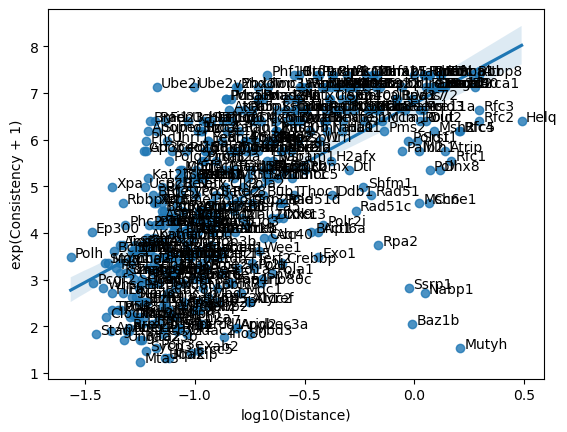

In [28]:
for alias in Z_paired.keys():
    sns.regplot(x = np.log10(distances.droplevel(0).loc[real_c.index]), y=np.exp(real_c + 1), x_ci = "sd")
    plt.ylabel("exp(Consistency + 1)")
    plt.xlabel("log10(Distance)")

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(np.log10(distances.droplevel(0).loc[real_c.index]), np.exp(real_c + 1), real_c.index.to_series(), plt.gca())
plt.show()

In [29]:
ldf = pd.DataFrame({
    "Distance": np.log10(distances.droplevel(0).loc[real_c.index]),
    "Consistency": np.exp(real_c + 1)
})
model = smf.ols(formula = "Consistency ~ Distance", data=ldf).fit()

with open('artifacts/summary.txt', 'w') as fh:
    fh.write(model.summary().as_text())

<AxesSubplot: xlabel='Consistency', ylabel='Gene'>

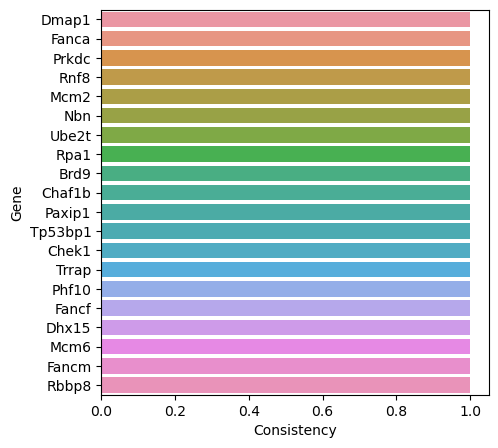

In [30]:
top_c = real_c.sort_values(ascending=False)[:20].to_frame()
top_c.columns = ["Consistency"]
top_c = top_c.sort_values("Consistency", ascending=False).reset_index()
plt.figure(figsize=(5, 5))
sns.barplot(data=top_c, x="Consistency", y="Gene")

<AxesSubplot: xlabel='Consistency', ylabel='Gene'>

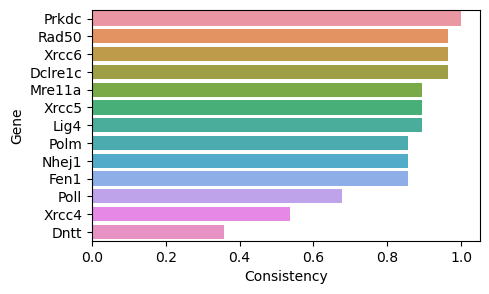

In [31]:
NHEJ = ['Xrcc6', 'Xrcc5', 'Dclre1c', 'Prkdc', 'Poll', 'Polm', 'Dntt', 'Lig4', 'Xrcc4', 'Nhej1', 'Rad50', 'Mre11a', 'Fen1']

nhej_c = real_c.loc[real_c.index.isin(NHEJ)].to_frame()
nhej_c.columns = ["Consistency"]
nhej_c = nhej_c.sort_values("Consistency", ascending=False).reset_index()
plt.figure(figsize=(5, 3))
sns.barplot(data=nhej_c, x="Consistency", y="Gene")

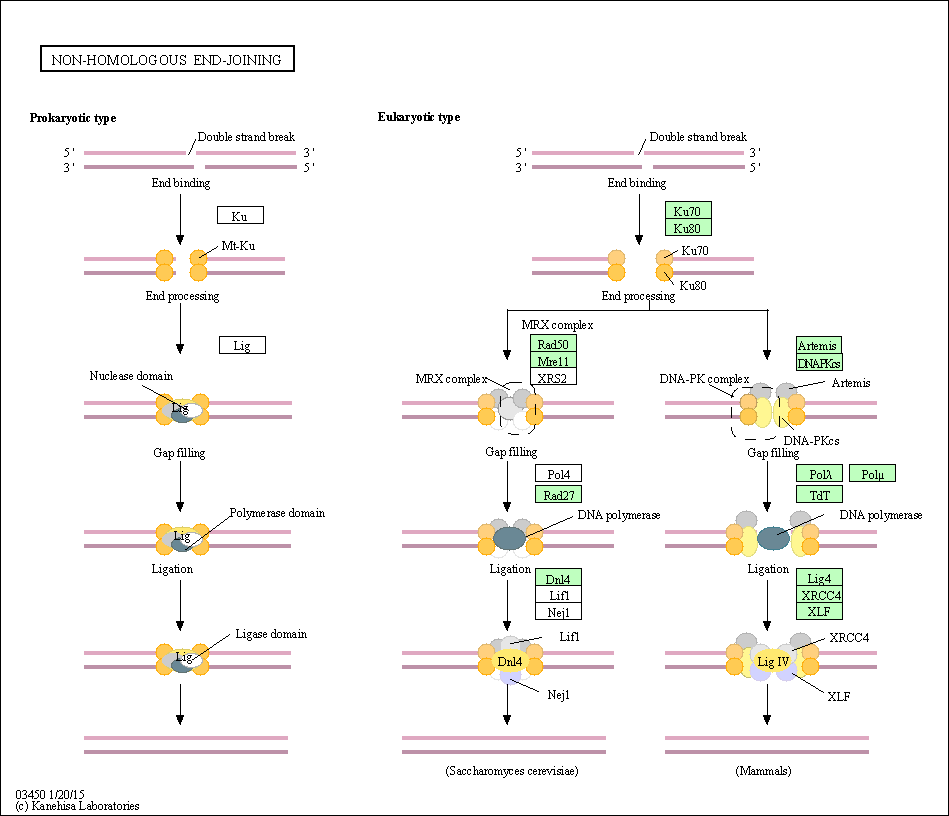

In [32]:
# Get map of fatty-acid biosynthesis
result = REST.kegg_get("mmu03450", "image").read()
Image(result)

In [33]:
result = REST.kegg_get("mmu03450", "kgml").read()
result

'<?xml version="1.0"?>\n<!DOCTYPE pathway SYSTEM "https://www.kegg.jp/kegg/xml/KGML_v0.7.2_.dtd">\n<!-- Creation date: Jan 20, 2015 17:57:27 +0900 (GMT+09:00) -->\n<pathway name="path:mmu03450" org="mmu" number="03450"\n         title="Non-homologous end-joining"\n         image="https://www.kegg.jp/kegg/pathway/mmu/mmu03450.png"\n         link="https://www.kegg.jp/kegg-bin/show_pathway?mmu03450">\n    <entry id="2" name="mmu:319583" type="gene"\n        link="https://www.kegg.jp/dbget-bin/www_bget?mmu:319583">\n        <graphics name="Lig4, 5830471N16Rik, tiny" fgcolor="#000000" bgcolor="#BFFFBF"\n             type="rectangle" x="819" y="577" width="46" height="17"/>\n    </entry>\n    <entry id="3" name="ko:K10983" type="ortholog"\n        link="https://www.kegg.jp/dbget-bin/www_bget?K10983">\n        <graphics name="K10983" fgcolor="#000000" bgcolor="#FFFFFF"\n             type="rectangle" x="558" y="611" width="46" height="17"/>\n    </entry>\n    <entry id="4" name="mmu:56626" typ

<AxesSubplot: xlabel='Consistency', ylabel='Gene'>

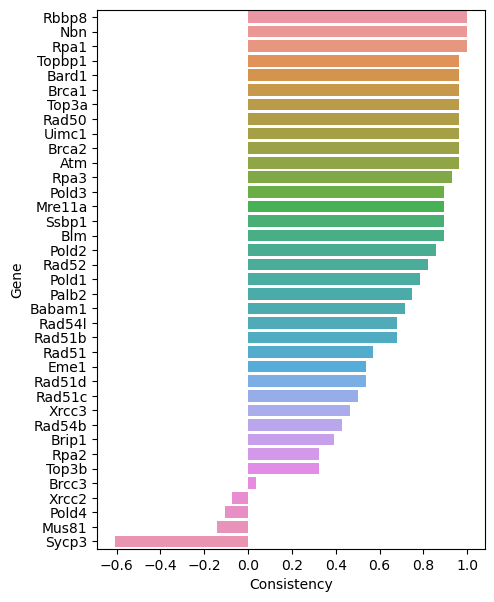

In [34]:
HR = ['Ssbp1', 'Rad50', 'Mre11a', 'Nbn', 'Atm', 'Brca1', 'Bard1', 'Rbbp8', 'Brip1', 'Topbp1'\
      , 'Abraxas1', 'Uimc1', 'Babam1', 'Babam2', 'Brcc3', 'Brcc3dc', 'Palb2', 'Brca2', 'Sem1'\
        , 'Sycp3', 'Rpa1', 'Rpa2', 'Rpa3', 'Rad51', 'Rad52', 'Rad51b', 'Rad51c', 'Rad51d', 'Xrcc2', 'Xrcc3', 'Rad54l'\
      , 'Rad54b', 'Pold1', 'Pold2', 'Pold3', 'Pold4', 'Blm', 'Top3b', 'Top3a', 'Mus81', 'Eme1']

hr_c = real_c.loc[real_c.index.isin(HR)].to_frame()
hr_c.columns = ["Consistency"]
hr_c = hr_c.sort_values("Consistency", ascending=False).reset_index()
plt.figure(figsize=(5, 7))
sns.barplot(data=hr_c, x="Consistency", y="Gene")

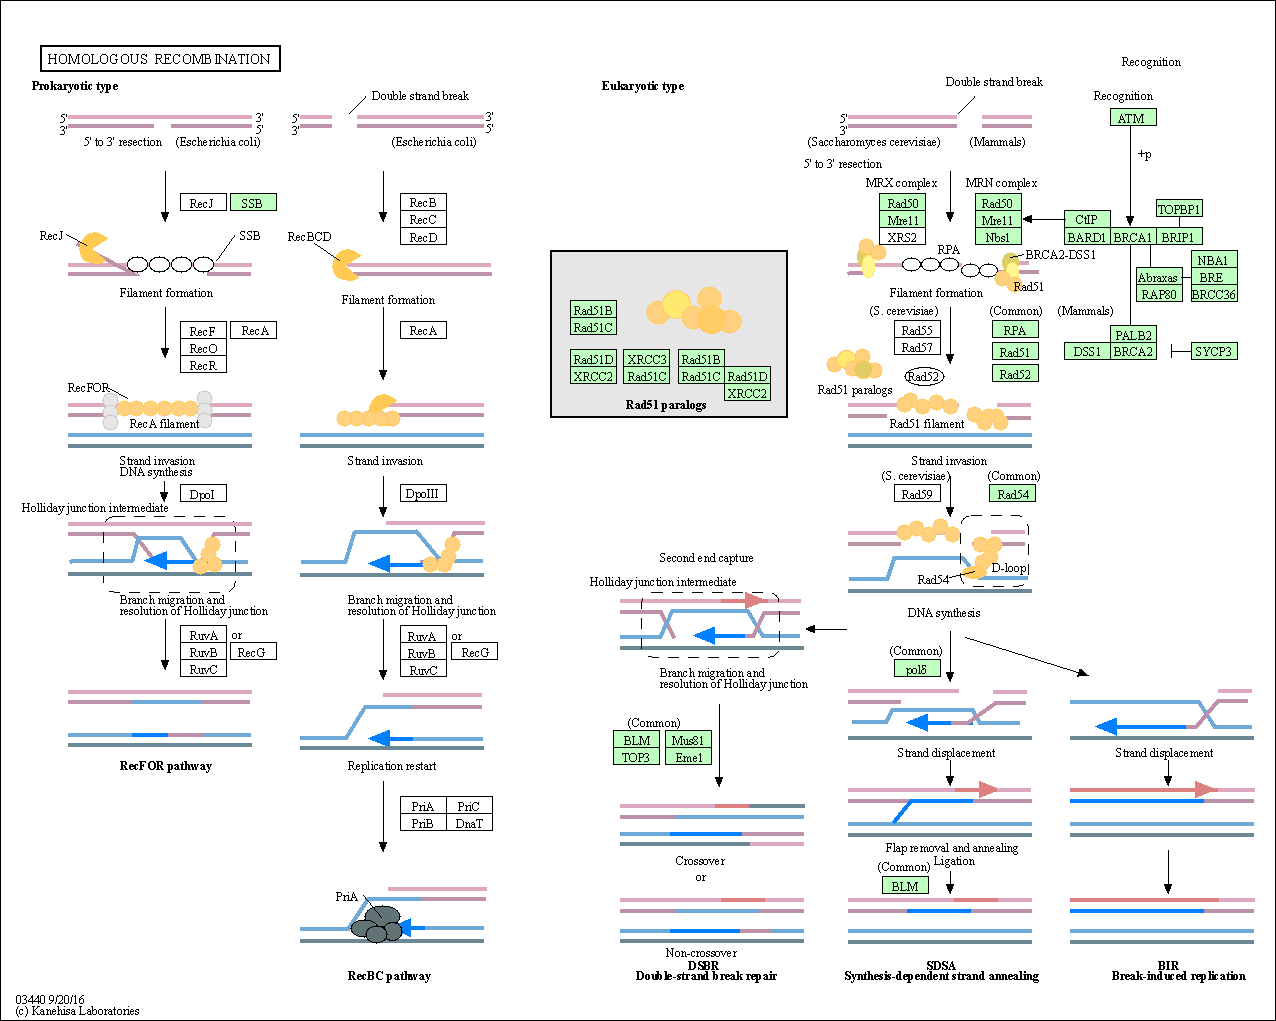

In [35]:
# Get map of fatty-acid biosynthesis
result = REST.kegg_get("mmu03440", "image").read()
Image(result)

<AxesSubplot: xlabel='Consistency', ylabel='Gene'>

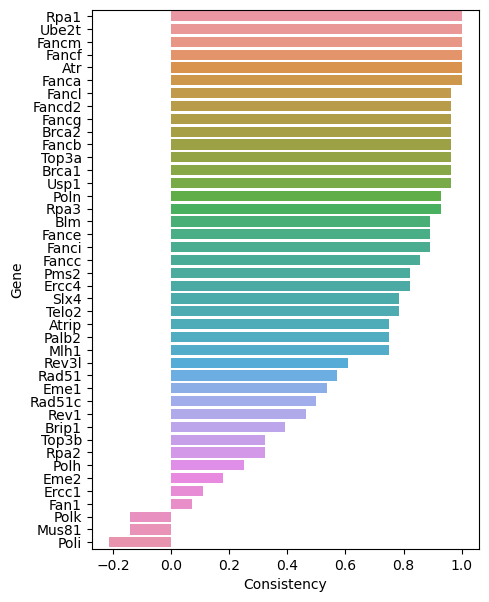

In [36]:
fanconi = ['Atrip', 'Atr', 'Fancm', 'Faap24', 'Cenps', 'Cenpx', 'Telo2', 'Hes1'\
 , 'Faap100', 'Fanca', 'Fancb', 'Fancc', 'Fance', 'Fancf', 'Fancg', 'Fancl'\
    , 'Wdr48', 'Usp1', 'Ube2t', 'Fanci', 'Fancd2', 'Brca2', 'Palb2', 'Rad51c'\
        , 'Rad51', 'Brca1', 'Brip1', 'Fan1', 'Mlh1', 'Pms2', 'Rev1', 'Rev3l', 'Polh'\
            , 'Poli', 'Polk', 'Poln', 'Rmi1', 'Rmi2', 'Top3b', 'Top3a', 'Blm', 'Rpa1', 'Rpa2'\
                , 'Rpa3', 'Mus81', 'Eme1', 'Eme2', 'Ercc4', 'Ercc1', 'Slx1b', 'Slx4']

fanconi_c = real_c.loc[real_c.index.isin(fanconi)].to_frame()
fanconi_c.columns = ["Consistency"]
fanconi_c = fanconi_c.sort_values("Consistency", ascending=False).reset_index()
plt.figure(figsize=(5, 7))
sns.barplot(data=fanconi_c, x="Consistency", y="Gene")


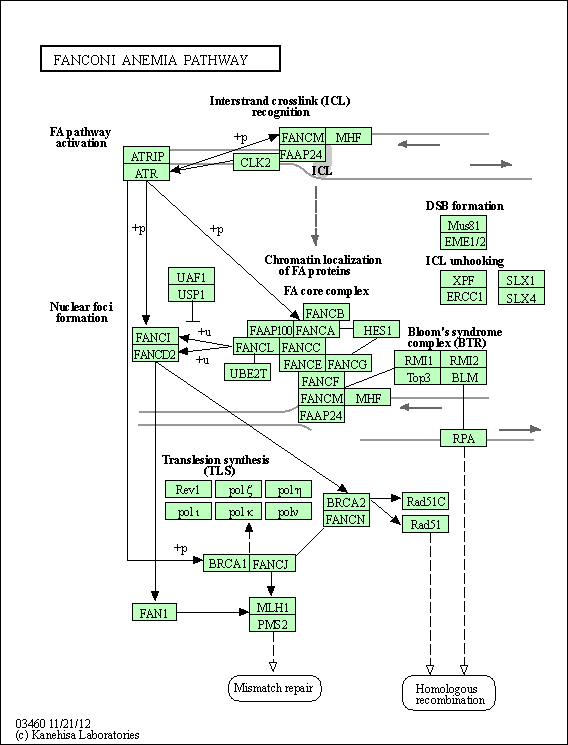

In [37]:
result = REST.kegg_get("mmu03460", "image").read()
Image(result)

# Consistency analysis

Looking at specific pathways, we can see that Mus81 is inconsistent and present in both Fancomi anemia and HR pathways. 
- Is it possible that inconsistent genes are least important? In that way, when they are knocked out, the results are still varied because they are not having a huge impact on the overall repair processes.
- Does consistency say something about how often a gene that lies in a branching path of an larger pathway (like Fan1 in Fanconi anemia) say something about how often that particular branch gets used?

# Integrated analysis

- Load all profiles for our target sites
- Calculate psuedo-controls per target site

In [38]:
Z_sample.update(pkl.load(open("{}/imputed_sample_data.pkl".format(get_experiment_artifacts(profile_type=SAMPLE)), "rb")))
Z_paired.update(pkl.load(open("{}/imputed_sample_data.pkl".format(get_experiment_artifacts(profile_type=PAIRED_SAMPLES)), "rb")))

# del Z_sample["MB01"]
# del Z_sample["MB02"]
# del Z_paired["T1"]

d_sample = pd.concat(Z_sample, axis=1).dropna()
print(d_sample.shape)
d_paired = pd.concat(Z_paired, axis=1).dropna()
print(d_paired.shape)

(322, 56)
(322, 28)


In [39]:
Xall_paired = d_paired.stack().stack()\
    .to_frame().reset_index()\
    .rename(columns={"level_2": "Sample", 0: "Value"})\
    .pivot(index=["Sample", "Gene"], columns=["lumc_category"], values="Value")
Xall_paired.index.unique("Sample")

Index(['Adamson_T1', 'T1', 'T2', 'T3'], dtype='object', name='Sample')

In [40]:
Xall_sample = d_sample.stack().stack()\
    .to_frame().reset_index()\
    .rename(columns={"level_2": "Sample", 0: "Value"})\
    .pivot(index=["Sample", "Gene"], columns=["lumc_category"], values="Value")
Xall_sample.index.unique("Sample")

Index(['K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1',
       'K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2', 'MB01', 'MB02', 'MB03',
       'MB04', 'MB05', 'MB06'],
      dtype='object', name='Sample')

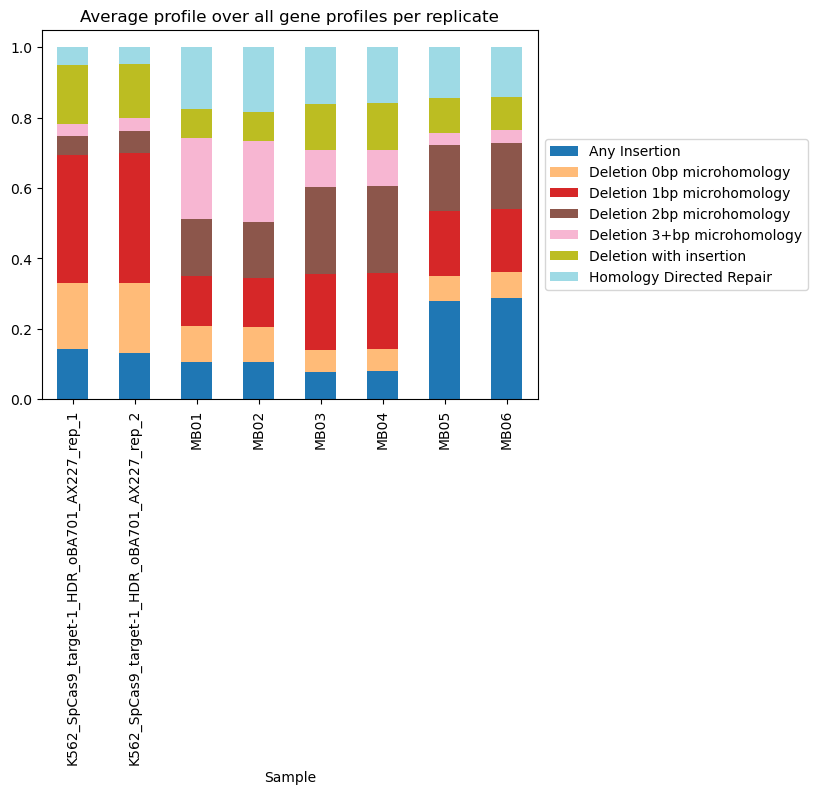

In [41]:
barplot_df = Xall_sample.groupby("Sample").mean().fillna(0)
f = plt.figure()
plt.title('Average profile over all gene profiles per replicate', color='black')
barplot_df.plot(kind="bar", stacked=True, ax=f.gca(), colormap="tab20")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [42]:
results = {}
for alias in Z_paired.keys():
    pca_scores, loadings, explained_variance_ratio, distances, pvalues = \
        logratio_outlier_detection(d_paired[alias], MinCovDet(random_state=0))
    results[alias] = pca_scores, loadings, explained_variance_ratio, distances, pvalues
    results[alias] = pd.Series(distances, index=d_paired[alias].index).sort_values(ascending=False)

In [43]:
pseudo_controls = {}
for alias in Z_paired.keys():
    pseudo_controls[alias] = results[alias].iloc[-len(controls):].index.to_series()
pseudo_controls[alias][:5]

Gene
Eme1            Eme1
Smarcad1    Smarcad1
Smarcd1      Smarcd1
Ring1          Ring1
Ep400          Ep400
Name: Gene, dtype: object

In [44]:
idx = pd.IndexSlice
other_genes = set(Xall_paired.index.unique(1)) - set(controls) 
for i in Z_paired.keys():
    other_genes -= set(pseudo_controls[i])
other_genes = list(other_genes)

map_samples_to_target = {
    "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1": "Adamson_T1",
    "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2": "Adamson_T1",
    "MB01": "T1",
    "MB02": "T1",
    "MB03": "T2",
    "MB04": "T2",
    "MB05": "T3",
    "MB06": "T3",
}

Xpseudodiff = {}
for alias in Z_sample.keys():
    Xpseudodiff[alias] = calculate_difference_to_controls(Xall_sample.loc[Xall_sample.index.get_level_values(0) == alias, :], pseudo_controls[map_samples_to_target[alias]], [alias]).loc[other_genes]
Xpseudodiff = pd.concat(Xpseudodiff.values(), axis=1)


(322, 7)
(29, 7)
(322, 7)
(7,)
(322, 7)
(322, 7)
(29, 7)
(322, 7)
(7,)
(322, 7)
(322, 7)
(29, 7)
(322, 7)
(7,)
(322, 7)
(322, 7)
(29, 7)
(322, 7)
(7,)
(322, 7)
(322, 7)
(29, 7)
(322, 7)
(7,)
(322, 7)
(322, 7)
(29, 7)
(322, 7)
(7,)
(322, 7)
(322, 7)
(29, 7)
(322, 7)
(7,)
(322, 7)
(322, 7)
(29, 7)
(322, 7)
(7,)
(322, 7)


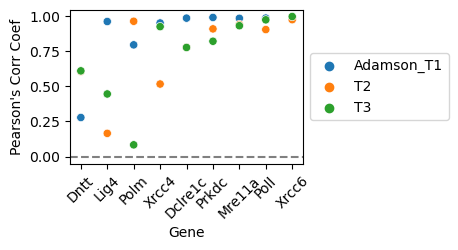

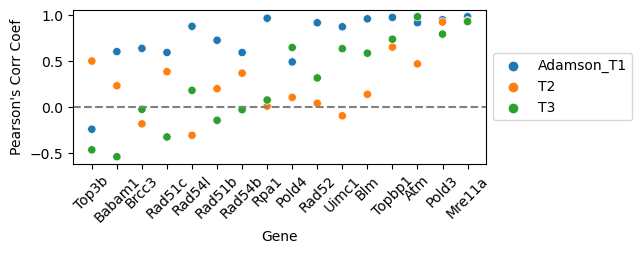

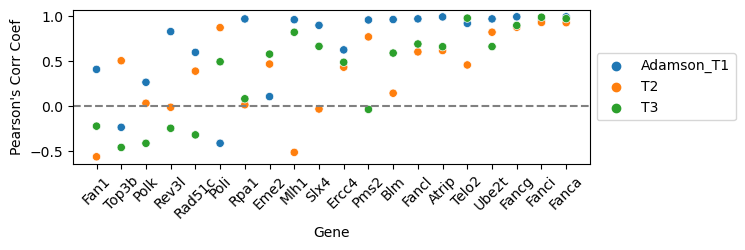

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/matplotlib/_tight_bbox.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/matplotlib/_tight_bbox.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  fig.bbox.width / w1, fig.bbox.height / h1)
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/matplotlib/patches.py:736: RuntimeWarning: invalid value encountered in double_scalars
  x1 = self.convert_xunits(self._x0 + self._width)
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/matplotlib/transforms.py:2046: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[0, 2] += tx


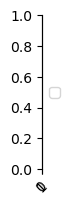

In [45]:
from src.visualization.plots import NHEJ_GENE_SET, HR_GENE_SET, FANCONI_ANEMIA_GENE_SET

all_c = []

for s in [NHEJ_GENE_SET, HR_GENE_SET, FANCONI_ANEMIA_GENE_SET, ["Polq"]]:
    method = "pearson"
    col_name = "{}'s Corr Coef".format(str.capitalize(method))
    intersect = np.intersect1d(s, Xpseudodiff.index.to_list())
    Xs = Xpseudodiff.loc[intersect]
    adamson_t1_corr = pd.DataFrame.corrwith(Xs["K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1"] , Xs["K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2"], axis=1, method="pearson")
    t2_corr = pd.DataFrame.corrwith(Xs["MB03"] , Xs["MB04"], axis=1, method="pearson")
    t3_corr = pd.DataFrame.corrwith(Xs["MB05"] , Xs["MB06"], axis=1, method="pearson")
    Xs_c = pd.concat([adamson_t1_corr, t2_corr, t3_corr], axis=1)
    Xs_c.columns=["Adamson_T1", "T2", "T3"]
    order = Xs_c.mean(axis=1).sort_values().index
    all_c.append(Xs_c)
    Xs_c = Xs_c.loc[order].stack().to_frame().reset_index().rename(columns={"level_1": "Target", 0: col_name})
    fig = plt.figure(figsize=(len(intersect)/3, 2))
    ax = plt.subplot(111)
    sns.scatterplot(data=Xs_c, x="Gene", y=col_name.format(), hue="Target")
    plt.xticks(rotation=45)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.axhline(0, color="grey", ls="--")
    plt.show()
    
all_c = pd.concat(all_c)

In [47]:
all_c

,Adamson_T1,T2,T3
Gene,,,
Dclre1c,0.987601,0.779529,0.778254
Dntt,0.278432,0.606952,0.611278
Lig4,0.963425,0.165283,0.446405
Mre11a,0.986297,0.941913,0.933467
Poll,0.988033,0.906032,0.975420
Polm,0.796904,0.965187,0.083390
Prkdc,0.992458,0.910877,0.822588
Xrcc4,0.952940,0.517414,0.926991
Xrcc6,0.980773,0.976718,0.999072


In [46]:
genes_of_interest = ["Lig4", "Dntt", "Polm", "Xrcc4", "Rad50", "Mre11a", "Xrcc5", "Xrcc6"] + \
    ["Top3b", "Mus81", "Xrcc2", "Pold2", "Rad51", "Polq"] + \
    ["Fan1", "Polk", "Polh", "Poli", "Fanca", "Fanci", "Fancb", "Brca1", "Brca2"]

genes_of_interest = sorted(genes_of_interest)

scplot_df = all_c.loc[genes_of_interest].stack().to_frame().reset_index().rename(columns={"level_1": "Target", 0: col_name})
fig = plt.figure(figsize=(len(genes_of_interest)/3, 2))
ax = plt.subplot(111)
sns.scatterplot(data=scplot_df, x="Gene", y=col_name.format(), hue="Target", palette="colorblind")
plt.xticks(rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(0, color="grey", ls="--")
plt.show()


KeyError: "['Brca1', 'Brca2', 'Fancb', 'Mus81', 'Pold2', 'Polh', 'Polq', 'Rad50', 'Rad51', 'Xrcc2', 'Xrcc5'] not in index"

In [ ]:
def consistency(x, change_df, sample1, sample2):
    return stats.spearmanr(change_df.loc[x,sample1].dropna(), change_df.loc[x,sample2].dropna())[0]

pseudo_c = {}
pseudo_c["Adamson_T1"] = Xpseudodiff.index.to_series().apply(lambda x: consistency(x, Xpseudodiff, \
            "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_1", "K562_SpCas9_target-1_HDR_oBA701_AX227_rep_2"))
# pseudo_c["T1"] = Xpseudodiff.index.to_series().apply(lambda x: consistency(x, Xpseudodiff, \
#             "MB01", "MB02"))
pseudo_c["T2"] = Xpseudodiff.index.to_series().apply(lambda x: consistency(x, Xpseudodiff, \
            "MB03", "MB04"))
pseudo_c["T3"] = Xpseudodiff.index.to_series().apply(lambda x: consistency(x, Xpseudodiff, \
            "MB05", "MB06"))
pseudo_c.keys()
pseudo_c = pd.concat(pseudo_c, axis=1)

<AxesSubplot: xlabel='Consistency', ylabel='Target'>

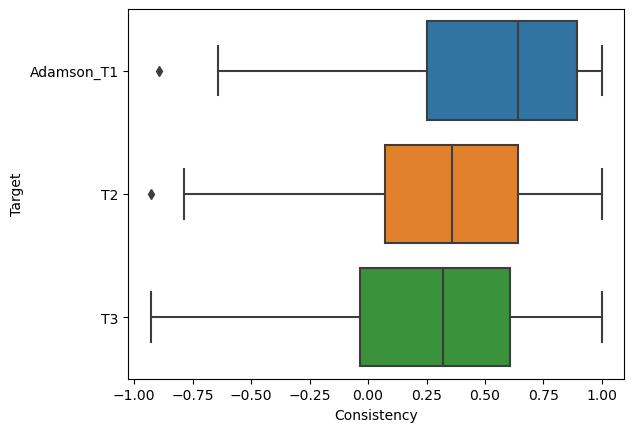

In [ ]:
sns.boxplot(data=pseudo_c.stack().reset_index().rename(columns={"level_1": "Target", 0: "Consistency"}), y="Target", x="Consistency")

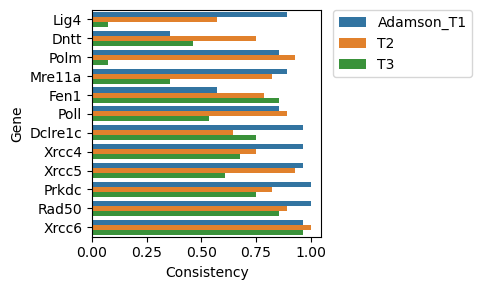

In [ ]:
nhej_c = pseudo_c.loc[pseudo_c.index.isin(NHEJ)].copy()
nhej_c["Average"] = nhej_c.abs().mean(axis=1)
nhej_c = nhej_c.sort_values(by="Average").drop("Average", axis=1).stack().reset_index().rename(columns={"level_1": "Target", 0: "Consistency"})
plt.figure(figsize=(5, 3))
sns.barplot(data=nhej_c, x="Consistency", y="Gene", hue="Target")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig("artifacts/nhej_consistency.pdf")


In [ ]:
result = REST.kegg_get("mmu03450", "image").read()
with open('artifacts/NHEJ.png', 'wb') as handler:
    handler.write(result)
image_1 = PILImage.open('artifacts/NHEJ.png')
im_1 = image_1.convert('RGB')
im_1.save('artifacts/NHEJ.pdf')

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 were given

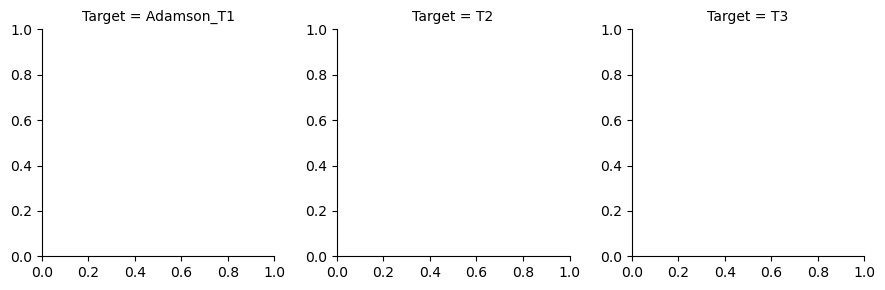

In [ ]:
# Plot outlier score along with consistency. Show that inconsistent genes here have lower scores. 
facet_df = pd.concat({
    "Consistency": nhej_c.pivot(index=["Gene"], columns=["Target"], values="Consistency"),
    "Score" : pd.concat(results, axis=1),
}, axis=1).dropna().stack().reset_index().rename(columns={"level_1": "Target"})

g = sns.FacetGrid(data=facet_df, col="Target", sharey=False)
# g.map_dataframe(sns.regplot, x="Consistency", y="Score")

def f(x, y, z, **kwargs):
    ax = sns.scatterplot(x,y,**kwargs)
    for i in range(len(x)):
        ax.annotate(str(z.values[i]), xy=(x.values[i], y.values[i]), fontsize=8,
                    xytext = (0,10), textcoords="offset points",
                color=kwargs.get("color","k"), 
                bbox=dict(pad=.9, alpha=0.2,color='none'),
                va='center', ha='center')
                

g.map(f, "Consistency", "Score", "Gene")


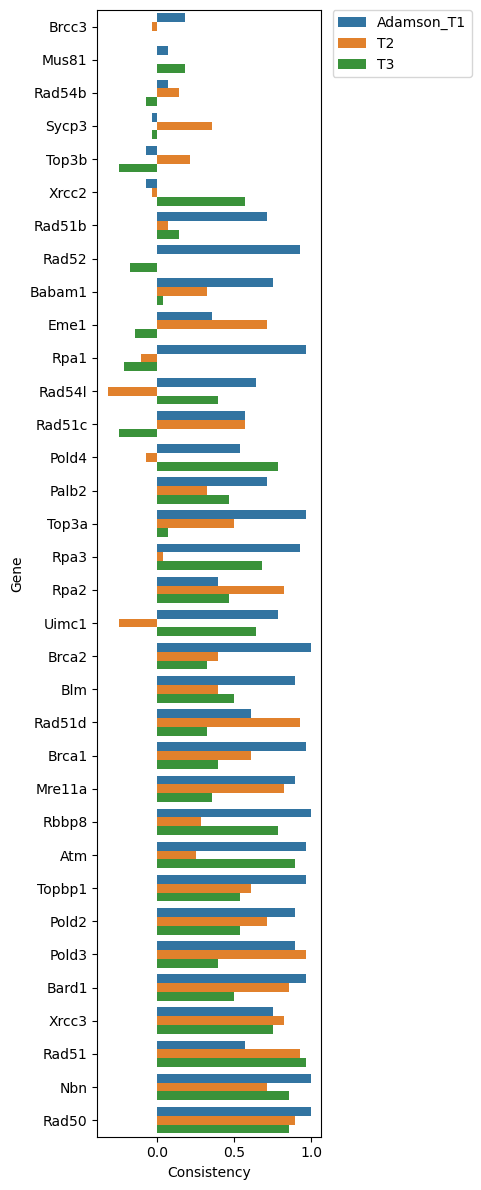

In [ ]:
hr_c = pseudo_c.loc[pseudo_c.index.isin(HR)].copy()
hr_c["Average"] = hr_c.abs().mean(axis=1)
hr_c = hr_c.sort_values(by="Average").drop("Average", axis=1).stack().reset_index().rename(columns={"level_1": "Target", 0: "Consistency"})
plt.figure(figsize=(5, 12))
sns.barplot(data=hr_c, x="Consistency", y="Gene", hue="Target")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig("artifacts/hr_consistency.pdf")
plt.show()

In [ ]:
result = REST.kegg_get("mmu03440", "image").read()
with open('artifacts/HR.png', 'wb') as handler:
    handler.write(result)
image_1 = PILImage.open('artifacts/HR.png')
im_1 = image_1.convert('RGB')
im_1.save('artifacts/HR.pdf')

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an erro

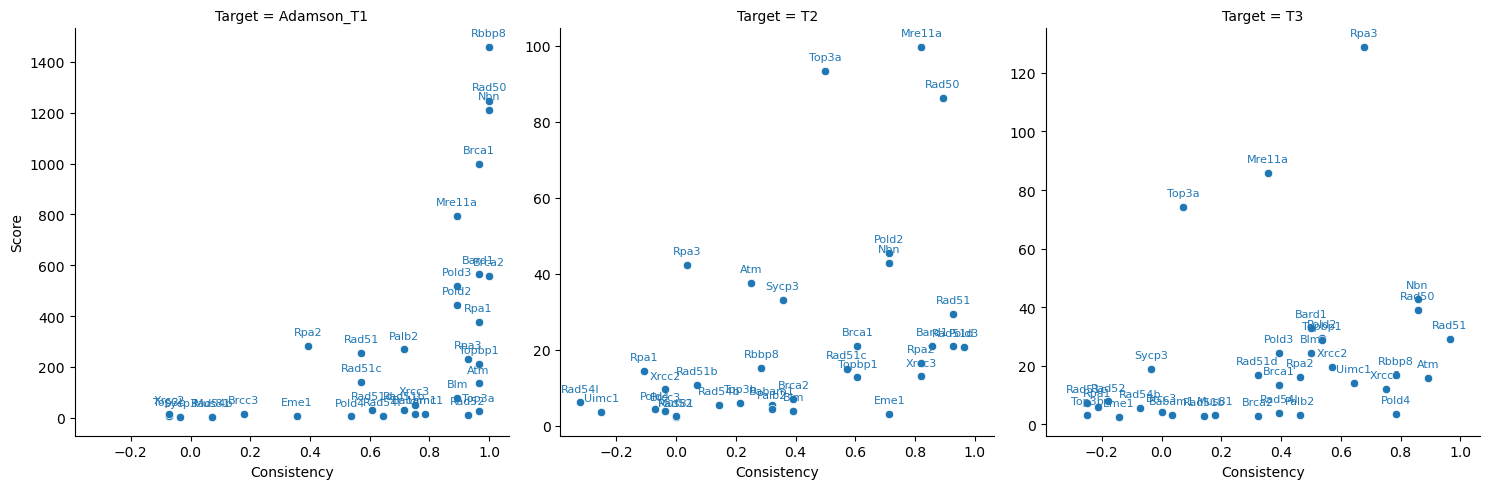

In [ ]:
# Plot outlier score along with consistency. Show that inconsistent genes here have lower scores. 
facet_df = pd.concat({
    "Consistency": hr_c.pivot(index=["Gene"], columns=["Target"], values="Consistency"),
    "Score" : pd.concat(results, axis=1)
}, axis=1).dropna().stack().reset_index()

g = sns.FacetGrid(data=facet_df, col="Target", sharey=False, height=5, aspect=1)
# g.map_dataframe(sns.regplot, x="Consistency", y="Score")

def f(x, y, z, **kwargs):
    ax = sns.scatterplot(x,y,**kwargs)
    for i in range(len(x)):
        ax.annotate(str(z.values[i]), xy=(x.values[i], y.values[i]), fontsize=8,
                    xytext = (0,10), textcoords="offset points",
                color=kwargs.get("color","k"), 
                bbox=dict(pad=.9, alpha=0.2,color='none'),
                va='center', ha='center')
                

g.map(f, "Consistency", "Score", "Gene")


### Homologous Recombination:
- RPA1 replaced by RPA2 and RP3
- Mus81, Top3(b?), Eme1 can be replaced by BLM. BLM has the most consistent impact. 

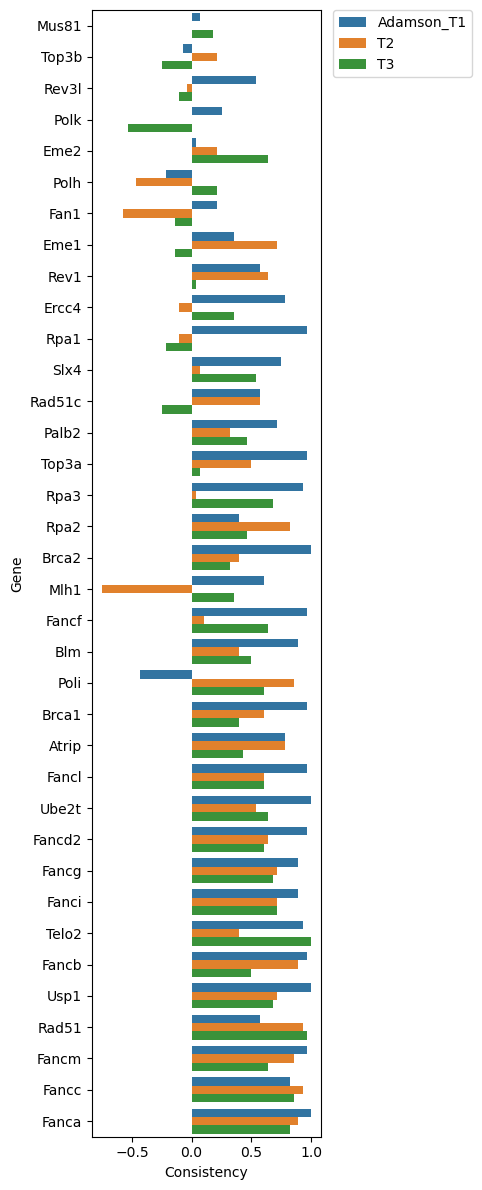

In [ ]:
fanconi_c = pseudo_c.loc[pseudo_c.index.isin(fanconi)].copy()
fanconi_c["Average"] = fanconi_c.abs().mean(axis=1)
fanconi_c = fanconi_c.sort_values(by="Average").drop("Average", axis=1).stack().reset_index().rename(columns={"level_1": "Target", 0: "Consistency"})

plt.figure(figsize=(5, 12))
sns.barplot(data=fanconi_c, x="Consistency", y="Gene", hue="Target")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.savefig("artifacts/fanconi_consistency.pdf")
plt.show()

In [ ]:
result = REST.kegg_get("mmu03460", "image").read()
with open('artifacts/fanconi.png', 'wb') as handler:
    handler.write(result)
image_1 = PILImage.open('artifacts/fanconi.png')
im_1 = image_1.convert('RGB')
im_1.save('artifacts/fanconi.pdf')

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an erro

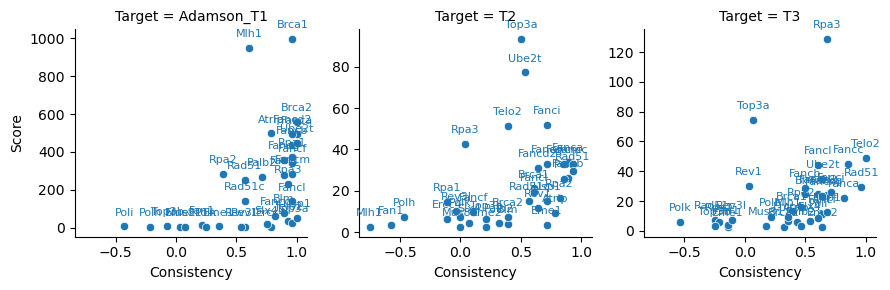

In [ ]:
# Plot outlier score along with consistency. Show that inconsistent genes here have lower scores. 
facet_df = pd.concat({
    "Consistency": fanconi_c.pivot(index=["Gene"], columns=["Target"], values="Consistency"),
    "Score" : pd.concat(results, axis=1)
}, axis=1).dropna().stack().reset_index()

g = sns.FacetGrid(data=facet_df, col="Target", sharey=False)
# g.map_dataframe(sns.regplot, x="Consistency", y="Score")

def f(x, y, z, **kwargs):
    ax = sns.scatterplot(x,y,**kwargs)
    for i in range(len(x)):
        ax.annotate(str(z.values[i]), xy=(x.values[i], y.values[i]), fontsize=8,
                    xytext = (0,10), textcoords="offset points",
                color=kwargs.get("color","k"), 
                bbox=dict(pad=.9, alpha=0.2,color='none'),
                va='center', ha='center')
                

g.map(f, "Consistency", "Score", "Gene")


### Fanconi amenia:
- It seems here that the inconsistent behavior can be partially explained by redundancy in the pathways. See Fan1, Polh, and Polk, are all part of redundant pathways. This also suggests that Fan1 is not used often, and Brca1/Fancj may be more dominant.
- Eme1 and Eme2 could be more dominant over Mus81 (DSB formation)
- RPA1 could be replaced by RPA2/3
- Poli could be replaced by the other polymerases. (unless they form part of a complex? Should check)

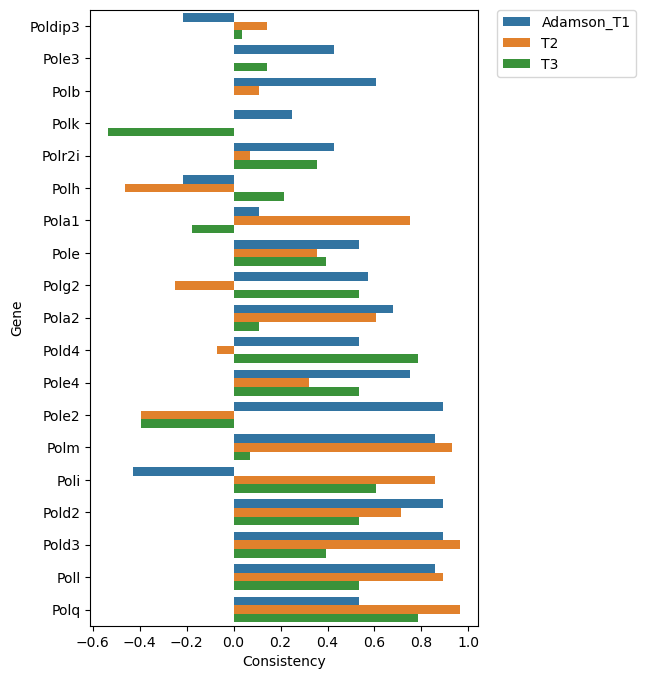

In [ ]:
polymerases = ['Polr3a','Pold4','Poln','Polr1c','Pole','Polr3g','Polr3gl','Pole2','Polr2m','Polr2h','Polr2g','Polr1has',
               'Polr2e','Polr3k','Polr2i','Polr3f','Polr1h','Polr1f','Polr1b','Polr2c','Polr2b','Polg2','Pold2','Polb','Pola1',
               'Polr1g','Polr3d','Polq','Polr1a','Polr2j','Pole4','Polr2l','Pold1','Polm','Polr2k','Poll','Polr2a','Polk','Polr2f',
               'Polr1e','Pold3','Polr1d','Polr3b','Polr2d','Polh', 'Polg', 'Poldip3', 'Poldip2', 'Polr3c', 'Pole3','Polrmt','Poli','Pola2','Polr3e','Polr3h']

pol_c = pseudo_c.loc[pseudo_c.index.isin(polymerases)].copy()
pol_c["Average"] = pol_c.abs().mean(axis=1)
pol_c = pol_c.sort_values(by="Average").drop("Average", axis=1).stack().reset_index().rename(columns={"level_1": "Target", 0: "Consistency"})

plt.figure(figsize=(5, 8))
sns.barplot(data=pol_c, x="Consistency", y="Gene", hue="Target")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/colm/anaconda3/envs/MUSICian/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an erro

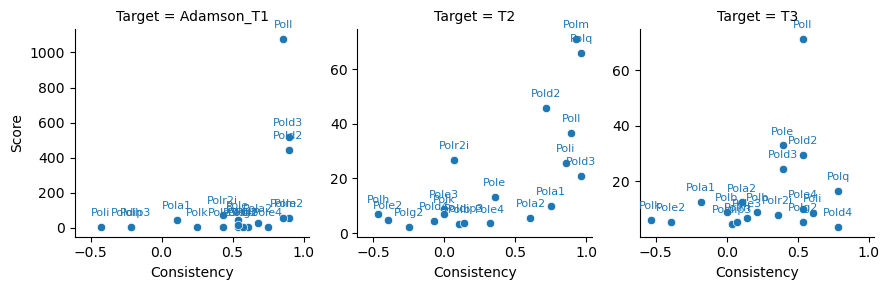

In [ ]:
# Plot outlier score along with consistency. Show that inconsistent genes here have lower scores. 
facet_df = pd.concat({
    "Consistency": pol_c.pivot(index=["Gene"], columns=["Target"], values="Consistency"),
    "Score" : pd.concat(results, axis=1)
}, axis=1).dropna().stack().reset_index()

g = sns.FacetGrid(data=facet_df, col="Target", sharey=False)
# g.map_dataframe(sns.regplot, x="Consistency", y="Score")

def f(x, y, z, **kwargs):
    ax = sns.scatterplot(x,y,**kwargs)
    for i in range(len(x)):
        ax.annotate(str(z.values[i]), xy=(x.values[i], y.values[i]), fontsize=8,
                    xytext = (0,10), textcoords="offset points",
                color=kwargs.get("color","k"), 
                bbox=dict(pad=.9, alpha=0.2,color='none'),
                va='center', ha='center')
                

g.map(f, "Consistency", "Score", "Gene")


- Genes almost never have high score and low consistency. This is good for our scoring metric.

## We show that...
- Inconsistency is a natural part of the data
- Our pseudo-controls do not differ from the real controls in the consistencies they create
- The average profile between then is similar (should do a statistical test to back this up)
- Show that some genes in some pathways are most consistent than others
- Hypothesize that the genes with inconsistent profiles may be part of the "least dominant" way through a particular repair process